In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Data Analysis

The following Python notebook aims to visualize and understand the dataset, so proper preprocessing and model features can be performed.

<font color='green'>TODO: change all the paths to the corresponding folder ones and remove the drive related cells. Check comments in green</font>

In [8]:
# Load the dataset
path = "/content/drive/MyDrive/_AI_Master/DataMining/Data Mining G25/reviews.joblib"
data = joblib.load(path)
texts, labels, folds = data[0], data[1], data[2]

df = pd.DataFrame({ "text": texts, "label": labels, "fold": folds})
df["label_name"] = df["label"].map({1: "Deceptive", 0: "Truthful"})

print("\nTotal reviews:", len(df))
print("Labels:", df['label_name'].value_counts().to_dict())
print("Folds:", df['fold'].value_counts().sort_index().to_dict())
df.head()


Total reviews: 800
Labels: {'Deceptive': 400, 'Truthful': 400}
Folds: {'fold1': 160, 'fold2': 160, 'fold3': 160, 'fold4': 160, 'fold5': 160}


,text,label,fold,label_name
0,We booked a room at the Hilton Chicago for two...,1,fold1,Deceptive
1,My husband and me reserved a room online for t...,1,fold1,Deceptive
2,When I went to The James hotel in Chicago I tr...,1,fold1,Deceptive
3,James Chicago would be one of the worst hotels...,1,fold1,Deceptive
4,"The Hilton Chicago, located on prime real esta...",1,fold1,Deceptive


We can start our analysis by seeing how the labels are distributed among the dfifferent folds.

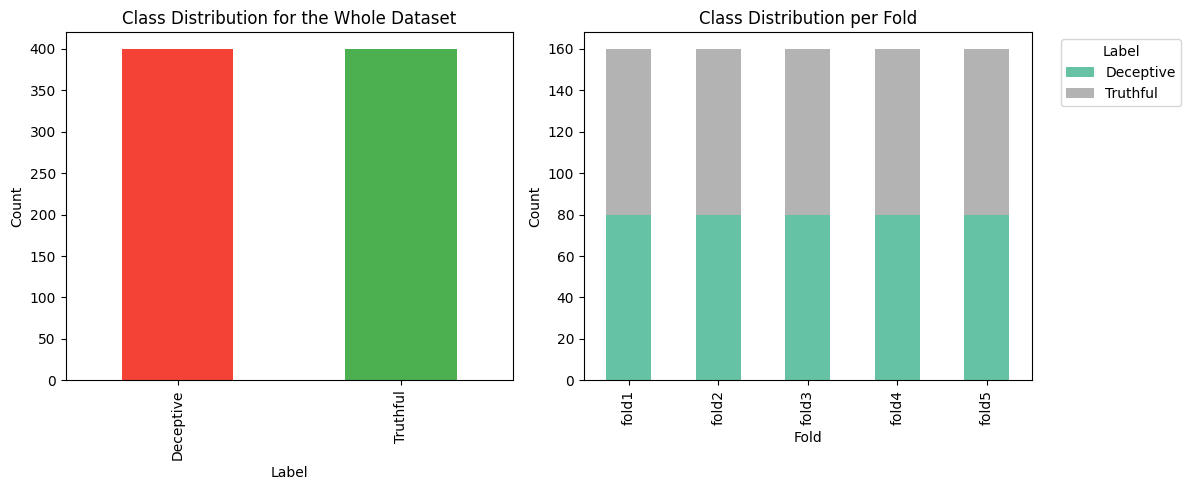

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Overall class distribution
df["label_name"].value_counts().plot(kind="bar", ax=axes[0], color=["#F44336", "#4CAF50"])
axes[0].set_title("Class Distribution for the Whole Dataset")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Count")

# Class distribution per fold
fold_label_counts = pd.crosstab(df["fold"], df["label_name"])
fold_label_counts.plot(kind="bar", stacked=True, ax=axes[1], colormap="Set2")
axes[1].set_title("Class Distribution per Fold")
axes[1].set_xlabel("Fold")
axes[1].set_ylabel("Count")
axes[1].legend(title="Label", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

We can as well check the length distirbution per review.  <font color='green'> -> does this inform us fo ranything in the preprocessing? Also here we are not removing stopwords which mught be interesting to do since it's the actual input to the models</font>

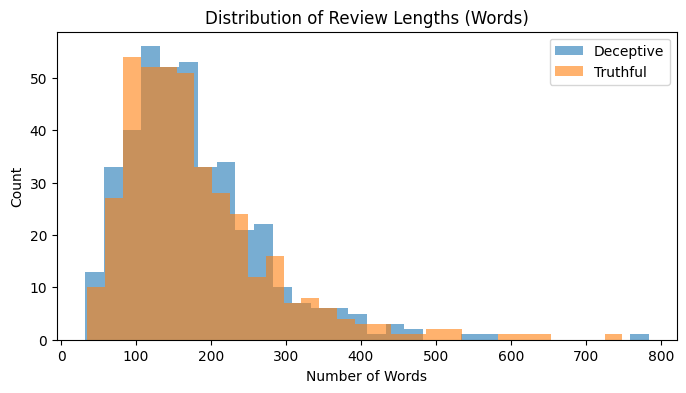


Review length stats:
            count    mean         std   min    25%    50%     75%    max
label_name                                                              
Deceptive   400.0  177.52   93.413596  32.0  115.0  160.0  222.50  784.0
Truthful    400.0  178.70  100.008922  35.0  112.0  157.0  220.25  749.0


In [14]:
# Review Lengths
df["word_count"] = df["text"].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,4))
plt.hist(df[df["label"]==1]["word_count"], bins=30, alpha=0.6, label="Deceptive")
plt.hist(df[df["label"]==0]["word_count"], bins=30, alpha=0.6, label="Truthful")
plt.title("Distribution of Review Lengths (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.legend()
plt.show()

print("\nReview length stats:")
print(df.groupby("label_name")["word_count"].describe())

We can visualzie thje most common words per each class <font color='green'> -> maybe mention in the report how we can see a lot of frequent words repeat between classes, which is an important factor to remove those words that are equally frequent for both classes</font>

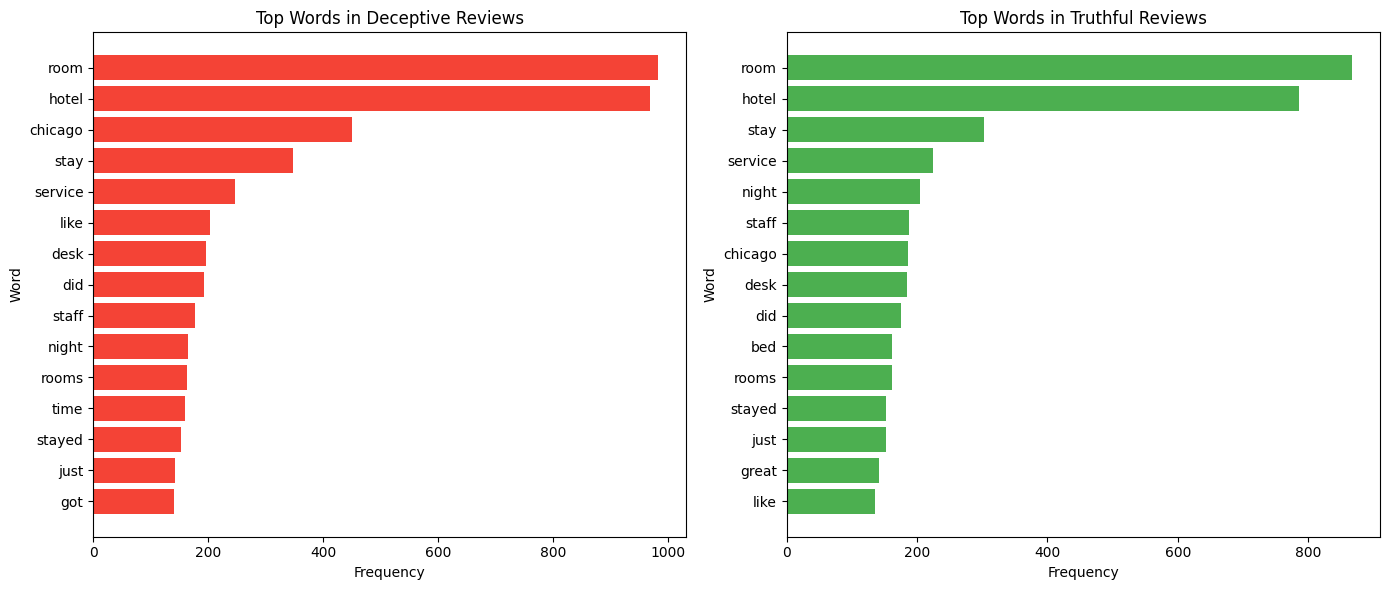

In [17]:
# Top Frequent Words per Class
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
classes = [(1, "Deceptive"), (0, "Truthful")]

for i, (label, name) in enumerate(classes):
    texts_subset = df[df["label"] == label]["text"]
    vectorizer = CountVectorizer(stop_words="english", max_features=15)
    X = vectorizer.fit_transform(texts_subset)

    words = vectorizer.get_feature_names_out()
    freqs = X.sum(axis=0).A1
    freq_df = pd.DataFrame({"word": words, "freq": freqs}).sort_values(by="freq", ascending=False)

    # Plot bar graph
    axes[i].barh(freq_df["word"], freq_df["freq"], color="#4CAF50" if label == 0 else "#F44336")
    axes[i].invert_yaxis()  # highest frequency on top
    axes[i].set_title(f"Top Words in {name} Reviews")
    axes[i].set_xlabel("Frequency")
    axes[i].set_ylabel("Word")

plt.tight_layout()
plt.show()


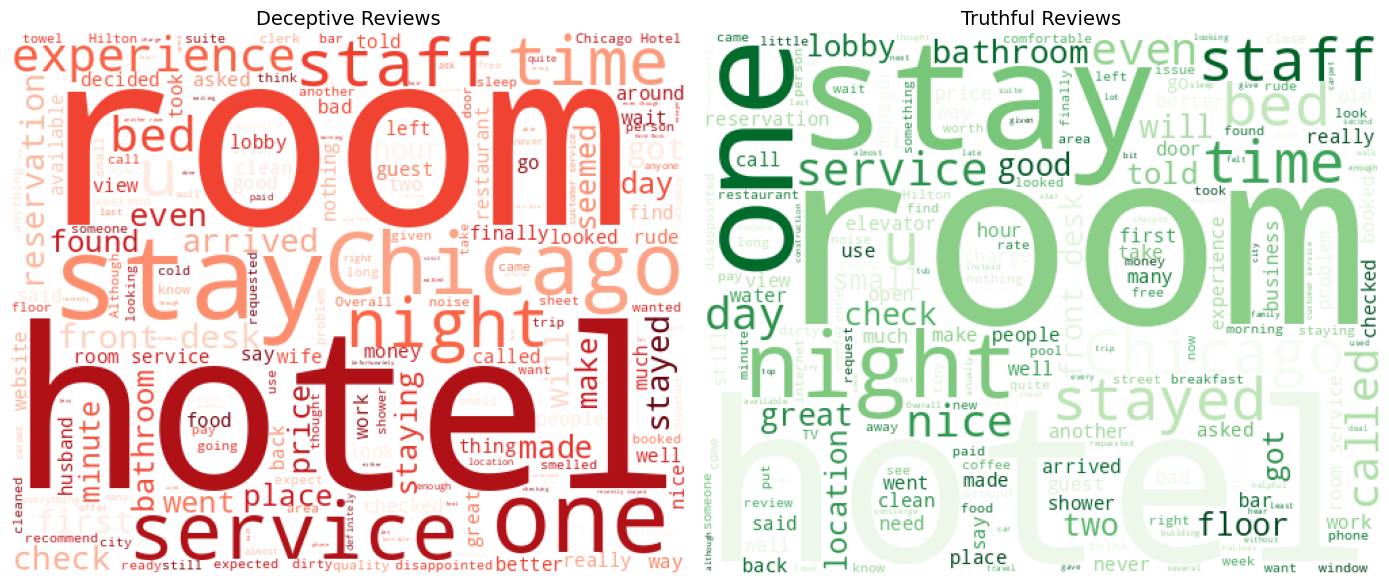

In [20]:
# Word Clouds
deceptive_text = " ".join(df[df["label"]==1]["text"])
truthful_text = " ".join(df[df["label"]==0]["text"])

fig, axes = plt.subplots(1, 2, figsize=(14,6))
axes[0].imshow(WordCloud(width=500, height=400, background_color="white", colormap="Reds").generate(deceptive_text))
axes[0].set_title("Deceptive Reviews", fontsize=14)
axes[0].axis("off")

axes[1].imshow(WordCloud(width=500, height=400, background_color="white", colormap="Greens").generate(truthful_text))
axes[1].set_title("Truthful Reviews", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()

We can do the same for the most frequent bigrams in each class. <font color='green'> -> mention in the report that here we can as well see many common bigrams between classes, however  we can see some that differ such as 'non smoking' or 'smoking area'</font>

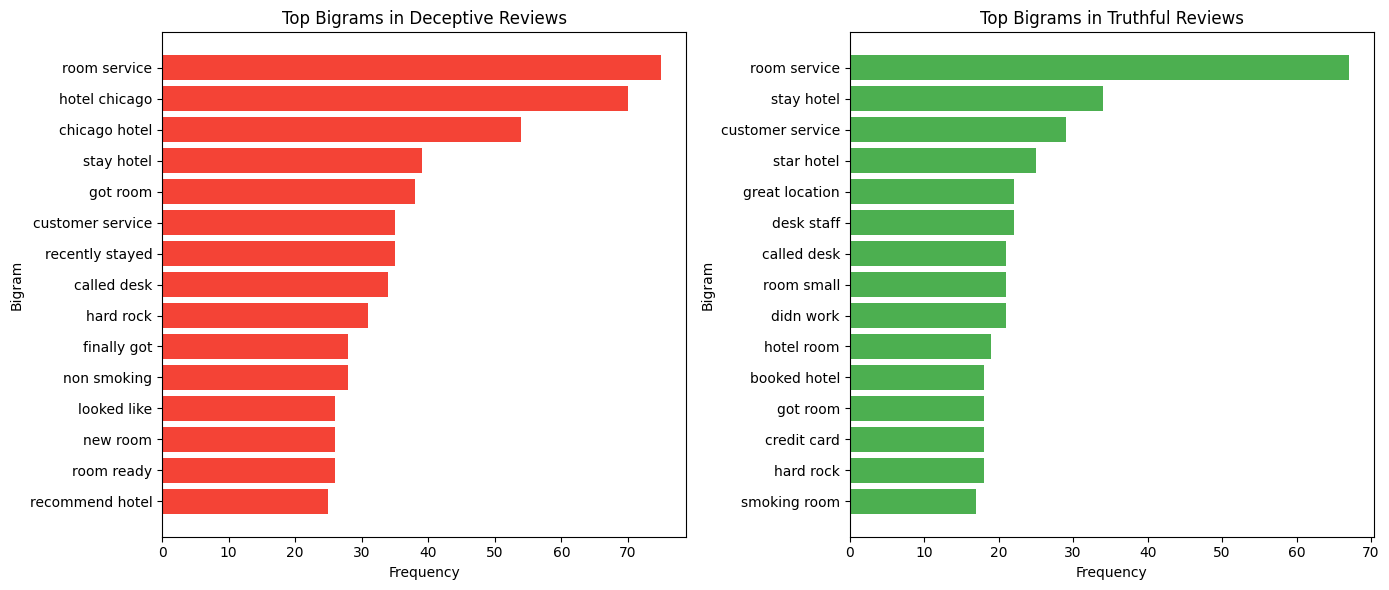

In [22]:
# Top Bigrams per Class
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, (label, name) in enumerate(classes):
    texts_subset = df[df["label"] == label]["text"]

    bigram_vectorizer = CountVectorizer(stop_words="english", ngram_range=(2, 2), max_features=15)
    X = bigram_vectorizer.fit_transform(texts_subset)
    bigrams = bigram_vectorizer.get_feature_names_out()
    freqs = X.sum(axis=0).A1
    bigram_df = pd.DataFrame({"bigram": bigrams, "freq": freqs}).sort_values(by="freq", ascending=False)

    # Plot horizontal bar chart
    axes[i].barh(bigram_df["bigram"], bigram_df["freq"], color="#4CAF50" if label == 0 else "#F44336")
    axes[i].invert_yaxis()  # show most frequent bigrams on top
    axes[i].set_title(f"Top Bigrams in {name} Reviews")
    axes[i].set_xlabel("Frequency")
    axes[i].set_ylabel("Bigram")

plt.tight_layout()
plt.show()


We can directley count how much vocabulary overlaps between classes and how much stays unique to each.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

#Vocab Overlap
cv = CountVectorizer(stop_words="english", min_df=2)
cv.fit(df["text"])
vocab = set(cv.get_feature_names_out())

cv_deceptive = CountVectorizer(stop_words="english", min_df=2).fit(df[df["label"]==1]["text"])
cv_truthful = CountVectorizer(stop_words="english", min_df=2).fit(df[df["label"]==0]["text"])

vocab_deceptive = set(cv_deceptive.get_feature_names_out())
vocab_truthful = set(cv_truthful.get_feature_names_out())

shared = vocab_deceptive & vocab_truthful
unique_deceptive = vocab_deceptive - vocab_truthful
unique_truthful = vocab_truthful - vocab_deceptive

print(f"Shared vocabulary: {len(shared)} words")
print(f"Unique to deceptive: {len(unique_deceptive)} words")
print(f"Unique to truthful: {len(unique_truthful)} words")


Shared vocabulary: 1615 words
Unique to deceptive: 637 words
Unique to truthful: 1009 words


Finally, we can use an NLP library to measure the sentiment polarization of the reviews in each class, where a polarity of -1 is a negative sentiment and 1 a positive one. <font color='green'> -> for the report maybe mention how we can appreciate a sligth tendency of truthful reviews to be more positive, while deceptive tend to be more negative. This can express an actual difference in teh writting style betweemn both classes'</font>

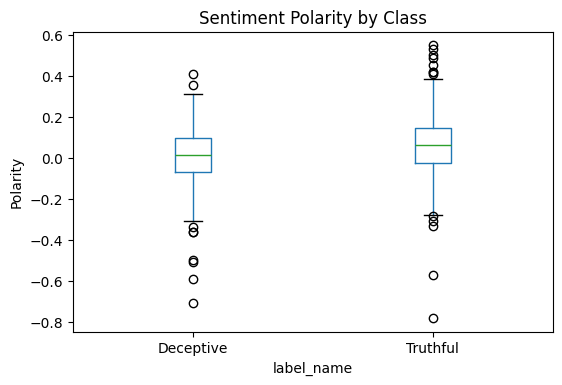

In [21]:
from textblob import TextBlob

#Sentiment
df["sentiment"] = df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df.groupby("label_name")["sentiment"].describe()
df.boxplot(column="sentiment", by="label_name", figsize=(6,4), grid=False)
plt.title("Sentiment Polarity by Class")
plt.suptitle("")
plt.ylabel("Polarity")
plt.show()

<font color='green'> Is there any extra analysis we can add related to the way we preprocess data? In the report we should show this graphs as a motivation and explanation for why we decided to preprocess the data in the way we did</font>